In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [14]:
embedding_dim = 8
max_number = 100
base = 10

#Random embeddings (CONTROL)
random_embedding = nn.Embedding(max_number + 1, embedding_dim)
torch.manual_seed(42)
with torch.no_grad():
    random_embedding.weight.copy_(torch.randn_like(random_embedding.weight))



# # #Abacus digit-wise embedding
digit_embedding = nn.Embedding(base, embedding_dim)
# positional_embedding = nn.Embedding(max_number, embedding_dim)


# def abacus_embed(n):
#     # digits = [int(d) for d in str(n).zfill(max_number)]
#     digits = [int(d) for d in str(n)]
#     digits = digits[::-1]
#     # digit_vecs = digit_embedding(torch.tensor(digits))
#     # pos_vecs = positional_embedding(torch.arange(len(digits)))
#     # pos_vecs = 0

#     embeddings = []
#     for i, d in enumerate(digits):
#         weight = 10 ** i #fixed positional weight
#         vec = digit_embedding(torch.tensor(d))
#         embeddings.append(vec * weight)

#     return torch.stack(embeddings).sum(dim=0)

#     # return (digit_vecs + pos_vecs).sum(dim=0)

positional_weight_embedding = nn.Embedding(10, 1)

def abacus_embed(n):
    digits = [int(d) for d in str(n)][::-1]
    embeddings = []
    for i, d in enumerate(digits):
        digit_vec = digit_embedding(torch.tensor(d))
        pos_weight = positional_weight_embedding(torch.tensor(i)).view(-1)
        embeddings.append(digit_vec * pos_weight)
    return torch.stack(embeddings).sum(dim=0)


In [15]:
# def abacus_embed(number, max_number=max_number, base=base, embedding_dim=embedding_dim, offset=0):

#     #int -> string -> list of digits
#     digits = [int(d) for d in str(number).zfill(max_number)]
    
#     #init matrix
#     embedding = np.zeros((max_number, embedding_dim))
    
#     for i, digit in enumerate(digits):
#         position = offset + i

#         # #One-hot encoding to embedding (PREFERENCE)
#         # one_hot = np.zeros(base)
#         # one_hot[digit] = 1

#         # embedding = np.dot(one_hot, embedding.weight.detach().numpy())

#         #Sinusoidal positional encoding (PREFERENCE)
#         pos_enc = np.array([
#             np.sin(position / (10000 ** (2 * j / embedding_dim))) if j % 2 == 0
#             else np.cos(position / (10000 ** (2 * j / embedding_dim)))
#             for j in range(embedding_dim)
#         ])

#         #
#         #Combine digit value and positional encoding
#         embedding[i] = digit * pos_enc
    
#     return torch.tensor(embedding.flatten(), dtype=torch.float32)


In [16]:
def evaluate_commutativity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            emb_sum = embedding_func(a) + embedding_func(b)
            emb_total = embedding_func(a + b)
            loss += torch.norm(emb_sum - emb_total) ** 2  # use 2 norm
    return loss / (11 * 11)  # normalize by number of terms

In [17]:
def evaluate_associativity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            for c in range(0, 11):
                emb_sum = embedding_func(a + b) + embedding_func(c)
                emb_total = embedding_func(a) + embedding_func(b + c)
                loss += torch.norm(emb_sum - emb_total) ** 2
    return loss / (11 * 11 * 11)

In [18]:
def evaluate_distributivity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            for c in range(0, 11):
                emb_sum = embedding_func(a) * (embedding_func(b) + embedding_func(c))
                emb_total = embedding_func(a * b) + embedding_func(a * c)
                loss += torch.norm(emb_sum - emb_total) ** 2
    return loss / (11 * 11 * 11)

In [19]:
numbers = list(range(0, 101))
before_embeddings = torch.stack([abacus_embed(n) for n in numbers])

Step 0: Loss = 9.815371
Step 10: Loss = 5.021316
Step 20: Loss = 2.676332
Step 30: Loss = 1.544172
Step 40: Loss = 0.914303
Step 50: Loss = 0.543642
Step 60: Loss = 0.331542
Step 70: Loss = 0.207009
Step 80: Loss = 0.129831
Step 90: Loss = 0.081228
Step 100: Loss = 0.050550
Step 110: Loss = 0.031086
Step 120: Loss = 0.018814
Step 130: Loss = 0.011188
Step 140: Loss = 0.006523
Step 150: Loss = 0.003724
Step 160: Loss = 0.002081
Step 170: Loss = 0.001137
Step 180: Loss = 0.000608
Step 190: Loss = 0.000318
Step 200: Loss = 0.000163
Step 210: Loss = 0.000081
Step 220: Loss = 0.000040
Step 230: Loss = 0.000019
Step 240: Loss = 0.000009
Step 250: Loss = 0.000004
Step 260: Loss = 0.000002
Step 270: Loss = 0.000001
Step 280: Loss = 0.000000
Step 290: Loss = 0.000000
Step 300: Loss = 0.000000
Step 310: Loss = 0.000000
Step 320: Loss = 0.000000
Step 330: Loss = 0.000000
Step 340: Loss = 0.000000
Step 350: Loss = 0.000000
Step 360: Loss = 0.000000
Step 370: Loss = 0.000000
Step 380: Loss = 0.0000

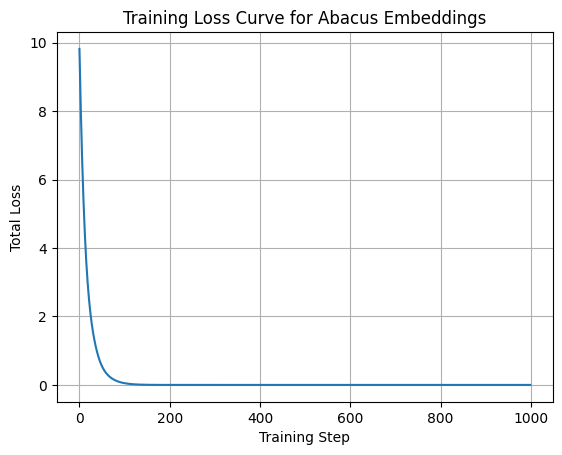

In [20]:
#total loss
def total_loss(embedding_func):
    return (evaluate_commutativity(embedding_func) +
            evaluate_associativity(embedding_func) +
            evaluate_distributivity(embedding_func))

#select optimizer
# optimizer = optim.Adam(digit_embedding.parameters(), lr=0.01)
optimizer = optim.Adam(list(digit_embedding.parameters()) + list(positional_weight_embedding.parameters()), lr=0.01)
#optimizer = optim.SGD(digit_embedding.parameters(), lr=0.01)

#training looop
losses = []
for step in range(1000):
    optimizer.zero_grad()
    loss = total_loss(abacus_embed)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss.item():.6f}")

plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Total Loss')
plt.title('Training Loss Curve for Abacus Embeddings')
plt.grid(True)
plt.show()


In [21]:
after_embeddings = torch.stack([abacus_embed(n) for n in numbers])

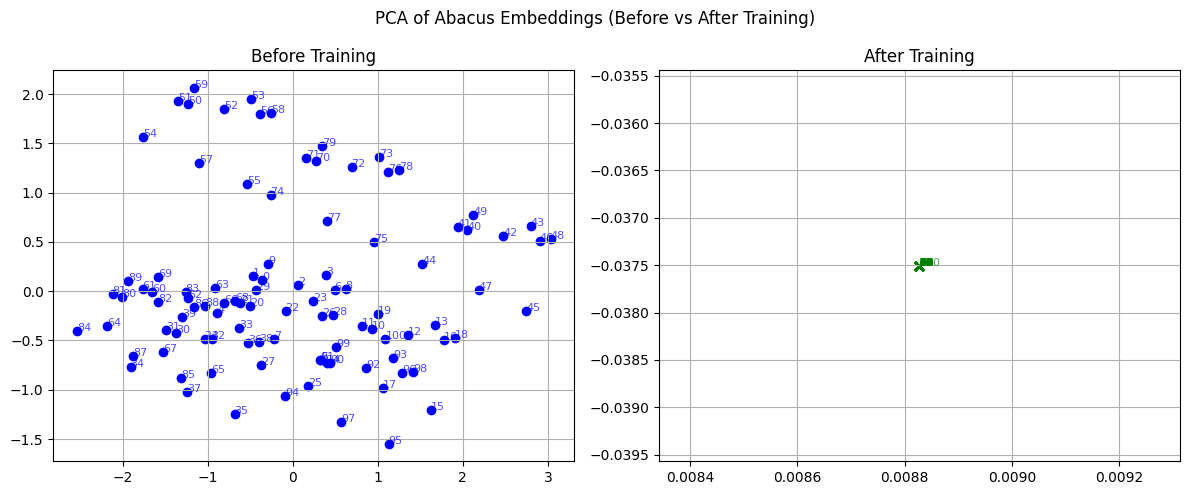

In [22]:
def PCA_plot(before_embeddings, after_embeddings, numbers):
    # Detach and convert
    before_np = before_embeddings.detach().numpy()
    after_np = after_embeddings.detach().numpy()

    # Stack together for PCA
    all_embeddings = np.concatenate([before_np, after_np], axis=0)

    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_embeddings)

    # Split back
    before_2d = reduced[:len(numbers)]
    after_2d = reduced[len(numbers):]

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(before_2d[:, 0], before_2d[:, 1], c='blue', label='Before Training', marker='o')
    for i, (x, y) in enumerate(before_2d):
        axs[0].text(x, y, str(numbers[i]), fontsize=8, color='blue', alpha=0.7)
    axs[0].set_title('Before Training')
    axs[0].grid(True)

    axs[1].scatter(after_2d[:, 0], after_2d[:, 1], c='green', label='After Training', marker='x')
    for i, (x, y) in enumerate(after_2d):
        axs[1].text(x, y, str(numbers[i]), fontsize=8, color='green', alpha=0.7)
    axs[1].set_title('After Training')
    axs[1].grid(True)

    plt.suptitle('PCA of Abacus Embeddings (Before vs After Training)')
    plt.tight_layout()
    plt.show()
PCA_plot(before_embeddings, after_embeddings, numbers)


# def PCA_plot():
#     numbers = list(range(0, 101))#0 to 100

#     # Get embeddings
#     abacus_embeddings = torch.stack([abacus_embed(n) for n in numbers])
#     random_embeddings = torch.stack([random_embedding(torch.tensor(n)) for n in numbers])

#     # Detach and convert to NumPy
#     abacus_np = abacus_embeddings.detach().numpy()
#     random_np = random_embeddings.detach().numpy()

#     # Concatenate for PCA
#     all_embeddings = np.concatenate([abacus_np, random_np], axis=0)

#     # PCA to 2D
#     pca = PCA(n_components=2)
#     reduced = pca.fit_transform(all_embeddings)

#     # Split back
#     abacus_2d = reduced[:len(numbers)]
#     random_2d = reduced[len(numbers):]

#     # Plot
#     plt.scatter(abacus_2d[:, 0], abacus_2d[:, 1], c='blue', label='Abacus Embedding', marker='o')
#     plt.scatter(random_2d[:, 0], random_2d[:, 1], c='red', label='Random Embedding', marker='x')

#     # Add number labels to each point
#     for i, (x, y) in enumerate(abacus_2d):
#         plt.text(x, y, str(numbers[i]), fontsize=8, color='blue', alpha=0.7)
#     for i, (x, y) in enumerate(random_2d):
#         plt.text(x, y, str(numbers[i]), fontsize=8, color='red', alpha=0.7)

#     plt.xlabel('PCA Dimension 1')
#     plt.ylabel('PCA Dimension 2')
#     plt.title('PCA of Abacus vs Random Embeddings (Labeled)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
# PCA_plot()